# Import Libraries

In [1]:
# Run in python console
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
from spacy.lang.en.examples import sentences 
spacy.cli.download("en_core_web_sm")

# Plotting tools
import pyLDAvis
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim # don't skip this
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('words')
words = set(nltk.corpus.words.words())

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\ivyha\AppData\Roaming\Python\Python37\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivyha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ivyha\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
stop_new = ['mrt', 'station', 'see', 'bus', 'buses', 'line', 'account', 'one', 'full',
                     'get', 'min', 'class', 'year', 'pm', '', 'take', 'taxi', 'allow', 'last', 'almost',
                     'post', 'start', 'cross', 'car_rental', 'comfortdelgro', 'singapore', 'grab',
                     'night', 'find', 'need', 'build', 'photo', 'video', 'leave', 'car', 'train', 
                     'think', 'food', 'make', 'set', 'fresh', 'sbs', 'driver', 'delgro', 'comfort',  
                     'move',  'ever', 'blue', 'uber', 'go', 'look', 'use', 'also', 'give', 
                     'many', 'come', 'lot', 'seem', 'guess', 'definitely', 'sure', 'keep', 'much', 'already', 
                     'do', 'lol', 'people', 'well', 'back', 'week', 'u', 'want', 'day', 'will', 'know', 
                     'even', 'really', 'said', 'say', 'cab', 'public transport', 'taxis', 'public', 
                     'transport', 'thing', 'still', 'got', 'now', 's', 'stop', 'around', 'another', 
                     'smrt', 'next', 'us', 'may', 'person', 'years', 'going', 'trains', 'way', 
                     'seat', 'guy', 'https', 'always', 'riders', 'cabbie', 'sg', 'drivers', 'auntie', 'man', 
                     'uncle', 'stops', 'someone', 'something', 'andy', 'cabs', 'cabbies', 'order', 'delivery', 
                     'gojek', 'quite','fucking', 'every', 'getting', 'trying', 'told', 'something', 'singaporean', 
                     'feel', 'lta', 'fuck', 'without', 'let', 'made', 'getting', 'passenger', 'restaurant', 'grabfood', 
                     'merchant', 'don', 't', 'customer', 'cars', 'actually', 'senior', 'entrepreneur', 'rental', 'cars', 'current']

stop_words.extend(stop_new)

# Import DataFrame

In [3]:
df_clean_cat_bcovid = pd.read_csv(r'../../../Data/Scrapping/Reddit/sentiment/df_clean_cat_bcovid_sent.csv')
df_clean_cat_acovid = pd.read_csv(r'../../../Data/Scrapping/Reddit/sentiment/df_clean_cat_acovid_sent.csv')

# Prepare DataFrame for Topic Modelling

In [4]:
df_bcovid_data = df_clean_cat_bcovid.text.values.tolist()
df_acovid_data = df_clean_cat_acovid.text.values.tolist()

df_bus_bcovid_data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'bus'].text.values.tolist()
df_bus_acovid_data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'bus'].text.values.tolist()

df_mrt_bcovid_data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'mrt'].text.values.tolist()
df_mrt_acovid_data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'mrt'].text.values.tolist()

df_taxi_bcovid_data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'taxi'].text.values.tolist()
df_taxi_acovid_data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'taxi'].text.values.tolist()

df_ph_bcovid_data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'private hire'].text.values.tolist()
df_ph_acovid_data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'private hire'].text.values.tolist()

df_cr_bcovid_data = df_clean_cat_bcovid[df_clean_cat_bcovid['category'] == 'car rental'].text.values.tolist()
df_cr_acovid_data = df_clean_cat_acovid[df_clean_cat_acovid['category'] == 'car rental'].text.values.tolist()

# Tokenize Each Sentence

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this.
Additionally I have set deacc=True to remove the punctuations.

Create Function

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

Execute Function

In [6]:
df_bcovid_data_words = list(sent_to_words(df_bcovid_data))
df_acovid_data_words = list(sent_to_words(df_acovid_data))

df_bus_bcovid_data_words = list(sent_to_words(df_bus_bcovid_data))
df_bus_acovid_data_words = list(sent_to_words(df_bus_acovid_data))

df_mrt_bcovid_data_words = list(sent_to_words(df_mrt_bcovid_data))
df_mrt_acovid_data_words = list(sent_to_words(df_mrt_acovid_data))

df_taxi_bcovid_data_words = list(sent_to_words(df_taxi_bcovid_data))
df_taxi_acovid_data_words = list(sent_to_words(df_taxi_acovid_data))

df_ph_bcovid_data_words = list(sent_to_words(df_ph_bcovid_data))
df_ph_acovid_data_words = list(sent_to_words(df_ph_acovid_data))

df_cr_bcovid_data_words = list(sent_to_words(df_cr_bcovid_data))
df_cr_acovid_data_words = list(sent_to_words(df_cr_acovid_data))

# Build Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document.
Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, 
quadgrams and more.

The two important arguments to Phrases are min_count and threshold.
The higher the values of these param, the harder it is for words to be combined to bigrams.

## Overall

In [7]:
# Build the bigram and trigram models
df_bcovid_data_bigram = gensim.models.Phrases(df_bcovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_bcovid_data_trigram = gensim.models.Phrases(df_bcovid_data_bigram[df_bcovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_bcovid_data_bigram_mod = gensim.models.phrases.Phraser(df_bcovid_data_bigram)
df_bcovid_data_trigram_mod = gensim.models.phrases.Phraser(df_bcovid_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_bcovid_data_trigram_mod[df_bcovid_data_bigram_mod[df_bcovid_data_words[1]]])

['so', 'on', 'my', 'way', 'back', 'home', 'my', 'taxi', 'broke', 'down', 'walked', 'the', 'highway', 'and', 'random', 'uncle', 'offered', 'to', 'send', 'me', 'back']


In [8]:
# Build the bigram and trigram models
df_acovid_data_bigram = gensim.models.Phrases(df_acovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_acovid_data_trigram = gensim.models.Phrases(df_acovid_data_bigram[df_acovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_acovid_data_bigram_mod = gensim.models.phrases.Phraser(df_acovid_data_bigram)
df_acovid_data_trigram_mod = gensim.models.phrases.Phraser(df_acovid_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_acovid_data_trigram_mod[df_acovid_data_bigram_mod[df_acovid_data_words[1]]])

['new', 'cabinet', 'announcement']


## Bus

In [9]:
# Build the bigram and trigram models
df_bus_bcovid_data_bigram = gensim.models.Phrases(df_bus_bcovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_bus_bcovid_data_trigram = gensim.models.Phrases(df_bus_bcovid_data_bigram[df_bus_bcovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_bus_bcovid_data_bigram_mod = gensim.models.phrases.Phraser(df_bus_bcovid_data_bigram)
df_bus_bcovid_data_trigram_mod = gensim.models.phrases.Phraser(df_bus_bcovid_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_bus_bcovid_data_trigram_mod[df_bus_bcovid_data_bigram_mod[df_bus_bcovid_data_words[1]]])

['prc', 'missed', 'her', 'stop', 'and', 'demands', 'bus', 'driver', 'to', 'turn', 'back', 'by', 'getting', 'down', 'and', 'blocking', 'the', 'bus']


In [10]:
# Build the bigram and trigram models
df_bus_acovid_data_bigram = gensim.models.Phrases(df_bus_acovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_bus_acovid_data_trigram = gensim.models.Phrases(df_bus_acovid_data_bigram[df_bus_acovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_bus_acovid_data_bigram_mod = gensim.models.phrases.Phraser(df_bus_acovid_data_bigram)
df_bus_acovid_data_trigram_mod = gensim.models.phrases.Phraser(df_bus_acovid_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_bus_acovid_data_trigram_mod[df_bus_acovid_data_bigram_mod[df_bus_acovid_data_words[1]]])

['someone', 'misplaced', 'their', 'glasses', 'at', 'bus', 'stop', 'left', 'it', 'in', 'ziplock', 'with', 'note', 'week', 'ago', 'noticed', 'this', 'today']


## MRT

In [11]:
# Build the bigram and trigram models
df_mrt_bcovid_data_bigram = gensim.models.Phrases(df_mrt_bcovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_mrt_bcovid_data_trigram = gensim.models.Phrases(df_mrt_bcovid_data_bigram[df_mrt_bcovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_mrt_bcovid_data_bigram_mod = gensim.models.phrases.Phraser(df_mrt_bcovid_data_bigram)
df_mrt_bcovid_data_trigram_mod = gensim.models.phrases.Phraser(df_mrt_bcovid_data_trigram)

# See trigram example
print(df_mrt_bcovid_data_trigram_mod[df_mrt_bcovid_data_bigram_mod[df_mrt_bcovid_data_words[1]]])

['why', 'the', 'auntie', 'force', 'open', 'the', 'mrt', 'door']


In [12]:
# Build the bigram and trigram models
df_mrt_acovid_data_bigram = gensim.models.Phrases(df_mrt_acovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_mrt_acovid_data_trigram = gensim.models.Phrases(df_mrt_acovid_data_bigram[df_mrt_acovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_mrt_acovid_data_bigram_mod = gensim.models.phrases.Phraser(df_mrt_acovid_data_bigram)
df_mrt_acovid_data_trigram_mod = gensim.models.phrases.Phraser(df_mrt_acovid_data_trigram)

# See trigram example
print(df_mrt_acovid_data_trigram_mod[df_mrt_acovid_data_bigram_mod[df_mrt_acovid_data_words[1]]])

['here', 'is', 'my', 'mom', 'standing', 'next', 'to', 'an', 'ad', 'of', 'herself', 'in', 'bedok', 'mrt']


## Taxi

In [13]:
# Build the bigram and trigram models
df_taxi_bcovid_data_bigram = gensim.models.Phrases(df_taxi_bcovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_taxi_bcovid_data_trigram = gensim.models.Phrases(df_taxi_bcovid_data_bigram[df_taxi_bcovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_taxi_bcovid_data_bigram_mod = gensim.models.phrases.Phraser(df_taxi_bcovid_data_bigram)
df_taxi_bcovid_data_trigram_mod = gensim.models.phrases.Phraser(df_taxi_bcovid_data_trigram)

# See trigram example
print(df_taxi_bcovid_data_trigram_mod[df_taxi_bcovid_data_bigram_mod[df_taxi_bcovid_data_words[1]]])

['so', 'on', 'my', 'way', 'back', 'home', 'my', 'taxi', 'broke', 'down', 'walked', 'the', 'highway', 'and', 'random', 'uncle', 'offered', 'to', 'send', 'me', 'back']


In [14]:
# Build the bigram and trigram models
df_taxi_acovid_data_bigram = gensim.models.Phrases(df_taxi_acovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_taxi_acovid_data_trigram = gensim.models.Phrases(df_taxi_acovid_data_bigram[df_taxi_acovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_taxi_acovid_data_bigram_mod = gensim.models.phrases.Phraser(df_taxi_acovid_data_bigram)
df_taxi_acovid_data_trigram_mod = gensim.models.phrases.Phraser(df_taxi_acovid_data_trigram)

# See trigram example
print(df_taxi_acovid_data_trigram_mod[df_taxi_acovid_data_bigram_mod[df_taxi_acovid_data_words[1]]])

['new', 'cabinet', 'announcement']


## Private Hire

In [15]:
# Build the bigram and trigram models
df_ph_bcovid_data_bigram = gensim.models.Phrases(df_ph_bcovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_ph_bcovid_data_trigram = gensim.models.Phrases(df_ph_bcovid_data_bigram[df_ph_bcovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_ph_bcovid_data_bigram_mod = gensim.models.phrases.Phraser(df_ph_bcovid_data_bigram)
df_ph_bcovid_data_trigram_mod = gensim.models.phrases.Phraser(df_ph_bcovid_data_trigram)

# See trigram example
print(df_ph_bcovid_data_trigram_mod[df_ph_bcovid_data_bigram_mod[df_ph_bcovid_data_words[1]]])

['you', 'know', 'how', 'there', 'this', 'chinese', 'saying', 'hao', 'xin', 'mei', 'hao', 'bao', 'good', 'heart', 'doesn', 'mean', 'got', 'good', 'returns', 'once', 'saw', 'this', 'auntie', 'in', 'chinatown', 'lose', 'balance', 'and', 'because', 'she', 'was', 'right', 'in', 'front', 'of', 'me', 'grabbed', 'her', 'shoulder', 'to', 'steady', 'her', 'after', 'she', 'was', 'back', 'on', 'her', 'two', 'feet', 'she', 'swung', 'around', 'with', 'her', 'trolley', 'and', 'started', 'screaming', 'at', 'me', 'in', 'hokkien', 'and', 'chinese', 'asking', 'me', 'why', 'push', 'her', 'what', 'the', 'fuck', 'is', 'wrong', 'with', 'me', 'crazy', 'boy', 'my', 'father', 'die', 'my', 'auntie', 'die', 'my', 'mother', 'die', 'have', 'cheebai', 'etc', 'etc', 'etc', 'this', 'was', 'like', 'so', 'elderly', 'rage', 'wasn', 'really', 'memeable', 'back', 'then', 'so', 'was', 'like', 'just', 'auntie', 'what', 'never', 'push', 'you', 'screaming', 'intensifies', 'started', 'walking', 'away', 'and', 'she', 'just', 'st

In [16]:
# Build the bigram and trigram models
df_ph_acovid_data_bigram = gensim.models.Phrases(df_ph_acovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_ph_acovid_data_trigram = gensim.models.Phrases(df_ph_acovid_data_bigram[df_ph_acovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_ph_acovid_data_bigram_mod = gensim.models.phrases.Phraser(df_ph_acovid_data_bigram)
df_ph_acovid_data_trigram_mod = gensim.models.phrases.Phraser(df_ph_acovid_data_trigram)

# See trigram example
print(df_ph_acovid_data_trigram_mod[df_ph_acovid_data_bigram_mod[df_ph_acovid_data_words[1]]])

['rant', 'on', 'grabfood', 'and', 'din', 'tai', 'fung', 'nex']


## Car Rental

In [17]:
# Build the bigram and trigram models
df_cr_bcovid_data_bigram = gensim.models.Phrases(df_cr_bcovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_cr_bcovid_data_trigram = gensim.models.Phrases(df_cr_bcovid_data_bigram[df_cr_bcovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_cr_bcovid_data_bigram_mod = gensim.models.phrases.Phraser(df_cr_bcovid_data_bigram)
df_cr_bcovid_data_trigram_mod = gensim.models.phrases.Phraser(df_cr_bcovid_data_trigram)

# See trigram example
print(df_cr_bcovid_data_trigram_mod[df_cr_bcovid_data_bigram_mod[df_cr_bcovid_data_words[1]]])

['driver', 'knocks', 'over', 'rental', 'car', 'company', 'worker', 'km', 'police', 'car', 'chase', 'in', 'telok', 'blangah', 'ensues']


In [18]:
# Build the bigram and trigram models
df_cr_acovid_data_bigram = gensim.models.Phrases(df_cr_acovid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_cr_acovid_data_trigram = gensim.models.Phrases(df_cr_acovid_data_bigram[df_cr_acovid_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_cr_acovid_data_bigram_mod = gensim.models.phrases.Phraser(df_cr_acovid_data_bigram)
df_cr_acovid_data_trigram_mod = gensim.models.phrases.Phraser(df_cr_acovid_data_trigram)

# See trigram example
print(df_cr_acovid_data_trigram_mod[df_cr_acovid_data_bigram_mod[df_cr_acovid_data_words[1]]])

['this', 'is', 'what', 'makes', 'me', 'mad', 'we', 'don', 'need', 'to', 'have', 'any', 'trade', 'offs', 'to', 'the', 'environment', 'to', 'make', 'carbon', 'neutral', 'transport', 'look', 'at', 'most', 'city', 'centres', 'or', 'neighbourhoods', 'in', 'densely', 'populated', 'areas', 'we', 'don', 'need', 'to', 'make', 'our', 'traffic', 'arteries', 'wider', 'to', 'accommodate', 'pmds', 'lots', 'of', 'hdb', 'estate', 'roads', 'especially', 'the', 'larger', 'avenues', 'are', 'lanes', 'wide', 'on', 'either', 'side', 'which', 'is', 'lot', 'cutting', 'one', 'lane', 'on', 'either', 'side', 'makes', 'it', 'very', 'bike', 'pmd', 'pma', 'friendly', 'mitigates', 'the', 'effect', 'it', 'has', 'on', 'current', 'car', 'traffic', 'and', 'it', 'will', 'incentivize', 'pmd', 'bike', 'adoption', 'instead', 'of', 'cars', 'instead', 'our', 'government', 'sees', 'cutting', 'trees', 'as', 'trade', 'off', 'to', 'widening', 'roads', 'or', 'building', 'any', 'project', 'they', 'desire', 'when', 'in', 'reality', 

# Define Functions

The bigrams model is ready. Let’s define the functions to remove the stopwords, 
make bigrams and lemmatization and call them sequentially.

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):

    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod, bigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Call the Functions

## Overall

In [20]:
# Remove Stop Words
df_bcovid_data_words_nostops = remove_stopwords(df_bcovid_data_words)

# Form Bigrams
df_bcovid_data_words_bigrams = make_bigrams(df_bcovid_data_words_nostops, df_bcovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_bcovid_data_lemmatized = lemmatization(df_bcovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_bcovid_data_lemmatized[:1])

[['understand', 'find', 'picture', 'take', 'ago']]


In [21]:
# Remove Stop Words
df_acovid_data_words_nostops = remove_stopwords(df_acovid_data_words)

# Form Bigrams
df_acovid_data_words_bigrams = make_bigrams(df_acovid_data_words_nostops, df_acovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_acovid_data_lemmatized = lemmatization(df_acovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_acovid_data_lemmatized[:1])

[['old', 'crown', 'stack', 'scrap']]


## Bus

In [22]:
# Remove Stop Words
df_bus_bcovid_data_words_nostops = remove_stopwords(df_bus_bcovid_data_words)

# Form Bigrams
df_bus_bcovid_data_words_bigrams = make_bigrams(df_bus_bcovid_data_words_nostops, df_bus_bcovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_bus_bcovid_data_lemmatized = lemmatization(df_bus_bcovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_bus_bcovid_data_lemmatized[:1])

[['confession', 'petty', 'rider']]


In [23]:
# Remove Stop Words
df_bus_acovid_data_words_nostops = remove_stopwords(df_bus_acovid_data_words)

# Form Bigrams
df_bus_acovid_data_words_bigrams = make_bigrams(df_bus_acovid_data_words_nostops, df_bus_acovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_bus_acovid_data_lemmatized = lemmatization(df_bus_acovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_bus_acovid_data_lemmatized[:1])

[['try', 'hand', 'editing', 'shoot', 'empty', 'upper_deck', 'sinister', 'apocalyptic', 'vibe']]


## MRT

In [24]:
# Remove Stop Words
df_mrt_bcovid_data_words_nostops = remove_stopwords(df_mrt_bcovid_data_words)

# Form Bigrams
df_mrt_bcovid_data_words_bigrams = make_bigrams(df_mrt_bcovid_data_words_nostops, df_mrt_bcovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_mrt_bcovid_data_lemmatized = lemmatization(df_mrt_bcovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_mrt_bcovid_data_lemmatized[:1])

[['force', 'door', 'open', 'get', 'stuck', 'little', 'insane', 'strength']]


In [25]:
# Remove Stop Words
df_mrt_acovid_data_words_nostops = remove_stopwords(df_mrt_acovid_data_words)

# Form Bigrams
df_mrt_acovid_data_words_bigrams = make_bigrams(df_mrt_acovid_data_words_nostops, df_mrt_acovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_mrt_acovid_data_lemmatized = lemmatization(df_mrt_acovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_mrt_acovid_data_lemmatized[:1])

[['redesign', 'station', 'famous', 'logo']]


## Taxi

In [26]:
# Remove Stop Words
df_taxi_bcovid_data_words_nostops = remove_stopwords(df_taxi_bcovid_data_words)

# Form Bigrams
df_taxi_bcovid_data_words_bigrams = make_bigrams(df_taxi_bcovid_data_words_nostops, df_taxi_bcovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_taxi_bcovid_data_lemmatized = lemmatization(df_taxi_bcovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_taxi_bcovid_data_lemmatized[:1])

[['understand', 'find', 'picture', 'take', 'ago']]


In [27]:
# Remove Stop Words
df_taxi_acovid_data_words_nostops = remove_stopwords(df_taxi_acovid_data_words)

# Form Bigrams
df_taxi_acovid_data_words_bigrams = make_bigrams(df_taxi_acovid_data_words_nostops, df_taxi_acovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_taxi_acovid_data_lemmatized = lemmatization(df_taxi_acovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_taxi_acovid_data_lemmatized[:1])

[['old', 'crown', 'stack', 'scrap']]


## Private Hire

In [28]:
# Remove Stop Words
df_ph_bcovid_data_words_nostops = remove_stopwords(df_ph_bcovid_data_words)

# Form Bigrams
df_ph_bcovid_data_words_bigrams = make_bigrams(df_ph_bcovid_data_words_nostops, df_ph_bcovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_ph_bcovid_data_lemmatized = lemmatization(df_ph_bcovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_ph_bcovid_data_lemmatized[:1])

[['rant']]


In [29]:
# Remove Stop Words
df_ph_acovid_data_words_nostops = remove_stopwords(df_ph_acovid_data_words)

# Form Bigrams
df_ph_acovid_data_words_bigrams = make_bigrams(df_ph_acovid_data_words_nostops, df_ph_acovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_ph_acovid_data_lemmatized = lemmatization(df_ph_acovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_ph_acovid_data_lemmatized[:1])

[['rant']]


## Car Rental

In [30]:
# Remove Stop Words
df_cr_bcovid_data_words_nostops = remove_stopwords(df_cr_bcovid_data_words)

# Form Bigrams
df_cr_bcovid_data_words_bigrams = make_bigrams(df_cr_bcovid_data_words_nostops, df_cr_bcovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_cr_bcovid_data_lemmatized = lemmatization(df_cr_bcovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_cr_bcovid_data_lemmatized[:1])

[['drive', 'illegally', 'plead', 'guilty', 'cause', 'death', 'motorcycle', 'pillion', 'rider']]


In [31]:
# Remove Stop Words
df_cr_acovid_data_words_nostops = remove_stopwords(df_cr_acovid_data_words)

# Form Bigrams
df_cr_acovid_data_words_bigrams = make_bigrams(df_cr_acovid_data_words_nostops, df_cr_acovid_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_cr_acovid_data_lemmatized = lemmatization(df_cr_acovid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_cr_acovid_data_lemmatized[:1])

[['inspire', 'electric', 'expressway']]


# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
# Let’s create them.

## Overall

In [32]:
# Create Dictionary
df_bcovid_data_id2word = corpora.Dictionary(df_bcovid_data_lemmatized)

# Create Corpus
df_bcovid_data_texts = df_bcovid_data_lemmatized

# Term Document Frequency
df_bcovid_data_corpus = [df_bcovid_data_id2word.doc2bow(text) for text in df_bcovid_data_texts]

# View
print(df_bcovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [33]:
# Create Dictionary
df_acovid_data_id2word = corpora.Dictionary(df_acovid_data_lemmatized)

# Create Corpus
df_acovid_data_texts = df_acovid_data_lemmatized

# Term Document Frequency
df_acovid_data_corpus = [df_acovid_data_id2word.doc2bow(text) for text in df_acovid_data_texts]

# View
print(df_acovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


## Bus

In [34]:
# Create Dictionary
df_bus_bcovid_data_id2word = corpora.Dictionary(df_bus_bcovid_data_lemmatized)

# Create Corpus
df_bus_bcovid_data_texts = df_bus_bcovid_data_lemmatized

# Term Document Frequency
df_bus_bcovid_data_corpus = [df_bus_bcovid_data_id2word.doc2bow(text) for text in df_bus_bcovid_data_texts]

# View
print(df_bus_bcovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [35]:
# Create Dictionary
df_bus_acovid_data_id2word = corpora.Dictionary(df_bus_acovid_data_lemmatized)

# Create Corpus
df_bus_acovid_data_texts = df_bus_acovid_data_lemmatized

# Term Document Frequency
df_bus_acovid_data_corpus = [df_bus_acovid_data_id2word.doc2bow(text) for text in df_bus_acovid_data_texts]

# View
print(df_bus_acovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


## MRT

In [36]:
# Create Dictionary
df_mrt_bcovid_data_id2word = corpora.Dictionary(df_mrt_bcovid_data_lemmatized)

# Create Corpus
df_mrt_bcovid_data_texts = df_mrt_bcovid_data_lemmatized

# Term Document Frequency
df_mrt_bcovid_data_corpus = [df_mrt_bcovid_data_id2word.doc2bow(text) for text in df_mrt_bcovid_data_texts]

# View
print(df_mrt_bcovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [37]:
# Create Dictionary
df_mrt_acovid_data_id2word = corpora.Dictionary(df_mrt_acovid_data_lemmatized)

# Create Corpus
df_mrt_acovid_data_texts = df_mrt_acovid_data_lemmatized

# Term Document Frequency
df_mrt_acovid_data_corpus = [df_mrt_acovid_data_id2word.doc2bow(text) for text in df_mrt_acovid_data_texts]

# View
print(df_mrt_acovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


## Taxi

In [38]:
# Create Dictionary
df_taxi_bcovid_data_id2word = corpora.Dictionary(df_taxi_bcovid_data_lemmatized)

# Create Corpus
df_taxi_bcovid_data_texts = df_taxi_bcovid_data_lemmatized

# Term Document Frequency
df_taxi_bcovid_data_corpus = [df_taxi_bcovid_data_id2word.doc2bow(text) for text in df_taxi_bcovid_data_texts]

# View
print(df_taxi_bcovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [39]:
# Create Dictionary
df_taxi_acovid_data_id2word = corpora.Dictionary(df_taxi_acovid_data_lemmatized)

# Create Corpus
df_taxi_acovid_data_texts = df_taxi_acovid_data_lemmatized

# Term Document Frequency
df_taxi_acovid_data_corpus = [df_taxi_acovid_data_id2word.doc2bow(text) for text in df_taxi_acovid_data_texts]

# View
print(df_taxi_acovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


## Private Hire

In [40]:
# Create Dictionary
df_ph_bcovid_data_id2word = corpora.Dictionary(df_ph_bcovid_data_lemmatized)

# Create Corpus
df_ph_bcovid_data_texts = df_ph_bcovid_data_lemmatized

# Term Document Frequency
df_ph_bcovid_data_corpus = [df_ph_bcovid_data_id2word.doc2bow(text) for text in df_ph_bcovid_data_texts]

# View
print(df_ph_bcovid_data_corpus[:1])

[[(0, 1)]]


In [41]:
# Create Dictionary
df_ph_acovid_data_id2word = corpora.Dictionary(df_ph_acovid_data_lemmatized)

# Create Corpus
df_ph_acovid_data_texts = df_ph_acovid_data_lemmatized

# Term Document Frequency
df_ph_acovid_data_corpus = [df_ph_acovid_data_id2word.doc2bow(text) for text in df_ph_acovid_data_texts]

# View
print(df_ph_acovid_data_corpus[:1])

[[(0, 1)]]


# Car Rental

In [42]:
# Create Dictionary
df_cr_bcovid_data_id2word = corpora.Dictionary(df_cr_bcovid_data_lemmatized)

# Create Corpus
df_cr_bcovid_data_texts = df_cr_bcovid_data_lemmatized

# Term Document Frequency
df_cr_bcovid_data_corpus = [df_cr_bcovid_data_id2word.doc2bow(text) for text in df_cr_bcovid_data_texts]

# View
print(df_cr_bcovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [43]:
# Create Dictionary
df_cr_acovid_data_id2word = corpora.Dictionary(df_cr_acovid_data_lemmatized)

# Create Corpus
df_cr_acovid_data_texts = df_cr_acovid_data_lemmatized

# Term Document Frequency
df_cr_acovid_data_corpus = [df_cr_acovid_data_id2word.doc2bow(text) for text in df_cr_acovid_data_texts]

# View
print(df_cr_acovid_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


# Build the Topic Model

Gensim creates a unique id for each word in the document.
The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document.

Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

id2word[0]
'addition'

Or, you can see a human-readable form of the corpus itself.

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('maryland_college', 1),
  (..truncated..)]]


Alright, without digressing further let’s jump back on track with the next step:

Building the topic model.

We have everything required to train the LDA model.
In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk.

update_every determines how often the model parameters should be updated and 
passes is the total number of training passes.

In [44]:
# Build LDA model
def lda_model(corpus, id2word, n_topics):

    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return model

The above LDA model is built with 20 different topics where each topic is a 
combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of 
each keyword using lda_model.print_topics() as shown next.

The output will look like this...


[(0,
  '0.016*"car" + 0.014*"power" + 0.010*"light" + 0.009*"drive" + 0.007*"mount" '
  '+ 0.007*"controller" + 0.007*"cool" + 0.007*"engine" + 0.007*"back" + '
  '0.006*"turn"'),
 (1,
  '0.072*"line" + 0.066*"organization" + 0.037*"write" + 0.032*"article" + '
  '0.028*"university" + 0.027*"nntp_post" + 0.026*"host" + 0.016*"reply" + '
  '0.014*"get" + 0.013*"thank"'),
 (2,
  '0.017*"patient" + 0.011*"study" + 0.010*"slave" + 0.009*"wing" + '
  '0.009*"disease" + 0.008*"food" + 0.008*"eat" + 0.008*"pain" + '
  '0.007*"treatment" + 0.007*"syndrome"'),
 (3,
  '0.013*"key" + 0.009*"use" + 0.009*"may" + 0.007*"public" + 0.007*"system" + '
  '0.007*"order" + 0.007*"government" + 0.006*"state" + 0.006*"provide" + '
  '0.006*"law"'),
  
  so on...



How to interpret this?

Topic 0 is a represented as _

0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” 
+ 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” 
+ 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are:
‘car’, ‘power’, ‘light’.. and so on
and the weight of ‘car’ on topic 0 is 0.016.

--> The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be?
You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?
https://www.machinelearningplus.com/wp-content/uploads/2018/03/Inferring-Topic-from-Keywords.png

# Calculate Model Perplexity and Topic Coherence

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## Overall

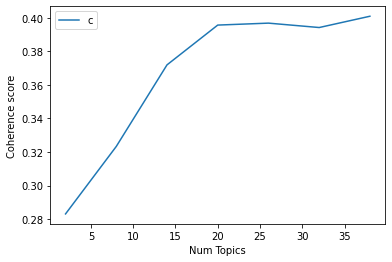

In [47]:
model_list, coherence_values = compute_coherence_values(dictionary=df_bcovid_data_id2word, corpus=df_bcovid_data_corpus, texts=df_bcovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Compute Perplexity
# print('\nPerplexity: ', df_bcovid_data_ldamodel.log_perplexity(df_bcovid_data_corpus))  # a measure of how good the model is. lower the better.

# #Compute Coherence Score
# df_bcovid_data_coherence_model_lda = CoherenceModel(model=df_bcovid_data_ldamodel, texts=df_bcovid_data_lemmatized, dictionary=df_bcovid_data_id2word, coherence='c_v')
# df_bcovid_data_coherence_lda = df_bcovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_bcovid_data_coherence_lda)


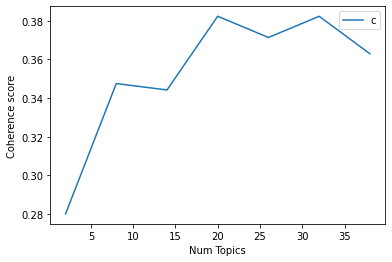

In [48]:
model_list, coherence_values = compute_coherence_values(dictionary=df_acovid_data_id2word, corpus=df_acovid_data_corpus, texts=df_acovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_acovid_data_model_list = []
# df_acovid_data_coherence_values = []
# df_acovid_data_model_topics = []

# for num_topics in range(1, 10,1):
#     df_acovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_acovid_data_corpus, id2word=df_acovid_data_id2word, num_topics=num_topics)
#     df_acovid_data_coherence_model_lda = CoherenceModel(model=df_acovid_data_ldamodel, texts=df_acovid_data_lemmatized, dictionary=df_acovid_data_id2word, coherence='c_v')
#     df_acovid_data_model_topics.append(num_topics)
#     df_acovid_data_model_list.append(df_acovid_data_lda_x)
#     df_acovid_data_coherence_values.append(df_acovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_acovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_acovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# Compute Perplexity
#print('\nPerplexity: ', df_acovid_data_ldamodel.log_perplexity(df_acovid_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
#df_acovid_data_coherence_model_lda = CoherenceModel(model=df_acovid_data_ldamodel, texts=df_acovid_data_lemmatized, dictionary=df_acovid_data_id2word, coherence='c_v')
#df_acovid_data_coherence_lda = df_acovid_data_coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', df_acovid_data_coherence_lda)


## Bus

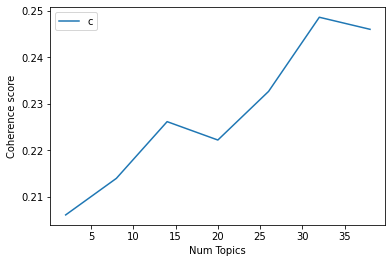

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=df_bus_bcovid_data_id2word, corpus=df_bus_bcovid_data_corpus, texts=df_bus_bcovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_bus_bcovid_data_model_list = []
# df_bus_bcovid_data_coherence_values = []
# df_bus_bcovid_data_model_topics = []

# for num_topics in range(1, 20,2):
#     df_bus_bcovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_bus_bcovid_data_corpus, id2word=df_bus_bcovid_data_id2word, num_topics=num_topics)
#     df_bus_bcovid_data_coherence_model_lda = CoherenceModel(model=df_bus_bcovid_data_ldamodel, texts=df_bus_bcovid_data_lemmatized, dictionary=df_bus_bcovid_data_id2word, coherence='c_v')
#     df_bus_bcovid_data_model_topics.append(num_topics)
#     df_bus_bcovid_data_model_list.append(df_bus_bcovid_data_lda_x)
#     df_bus_bcovid_data_coherence_values.append(df_bus_bcovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_bus_bcovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_bus_bcovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# Compute Perplexity
#print('\nPerplexity: ', df_bus_bcovid_data_ldamodel.log_perplexity(df_bus_bcovid_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
#df_bus_bcovid_data_coherence_model_lda = CoherenceModel(model=df_bus_bcovid_data_ldamodel, texts=df_bus_bcovid_data_lemmatized, dictionary=df_bus_bcovid_data_id2word, coherence='c_v')
#df_bus_bcovid_data_coherence_lda = df_bus_bcovid_data_coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', df_bus_bcovid_data_coherence_lda)


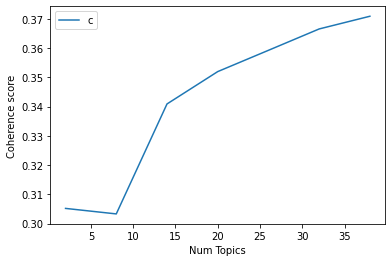

In [50]:
model_list, coherence_values = compute_coherence_values(dictionary=df_bus_acovid_data_id2word, corpus=df_bus_acovid_data_corpus, texts=df_bus_acovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_bus_acovid_data_model_list = []
# df_bus_acovid_data_coherence_values = []
# df_bus_acovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_bus_acovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_bus_acovid_data_corpus, id2word=df_bus_acovid_data_id2word, num_topics=num_topics)
#     df_bus_acovid_data_coherence_model_lda = CoherenceModel(model=df_bus_acovid_data_ldamodel, texts=df_bus_acovid_data_lemmatized, dictionary=df_bus_acovid_data_id2word, coherence='c_v')
#     df_bus_acovid_data_model_topics.append(num_topics)
#     df_bus_acovid_data_model_list.append(df_bus_acovid_data_lda_x)
#     df_bus_acovid_data_coherence_values.append(df_bus_acovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_bus_acovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_bus_acovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()


# Compute Perplexity
#print('\nPerplexity: ', df_bus_acovid_data_ldamodel.log_perplexity(df_bus_acovid_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
#df_bus_acovid_data_coherence_model_lda = CoherenceModel(model=df_bus_acovid_data_ldamodel, texts=df_bus_acovid_data_lemmatized, dictionary=df_bus_acovid_data_id2word, coherence='c_v')
#df_bus_acovid_data_coherence_lda = df_bus_acovid_data_coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', df_bus_acovid_data_coherence_lda)


## MRT

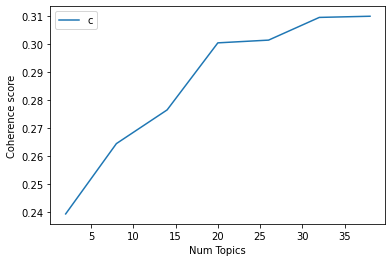

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary=df_mrt_bcovid_data_id2word, corpus=df_mrt_bcovid_data_corpus, texts=df_mrt_bcovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_mrt_bcovid_data_model_list = []
# df_mrt_bcovid_data_coherence_values = []
# df_mrt_bcovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_mrt_bcovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_mrt_bcovid_data_corpus, id2word=df_mrt_bcovid_data_id2word, num_topics=num_topics)
#     df_mrt_bcovid_data_coherence_model_lda = CoherenceModel(model=df_mrt_bcovid_data_ldamodel, texts=df_mrt_bcovid_data_lemmatized, dictionary=df_mrt_bcovid_data_id2word, coherence='c_v')
#     df_mrt_bcovid_data_model_topics.append(num_topics)
#     df_mrt_bcovid_data_model_list.append(df_mrt_bcovid_data_lda_x)
#     df_mrt_bcovid_data_coherence_values.append(df_mrt_bcovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_mrt_bcovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_mrt_bcovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# Compute Perplexity
#print('\nPerplexity: ', df_mrt_bcovid_data_ldamodel.log_perplexity(df_mrt_bcovid_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# df_mrt_bcovid_data_coherence_model_lda = CoherenceModel(model=df_mrt_bcovid_data_ldamodel, texts=df_mrt_bcovid_data_lemmatized, dictionary=df_mrt_bcovid_data_id2word, coherence='c_v')
# df_mrt_bcovid_data_coherence_lda = df_mrt_bcovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_mrt_bcovid_data_coherence_lda)


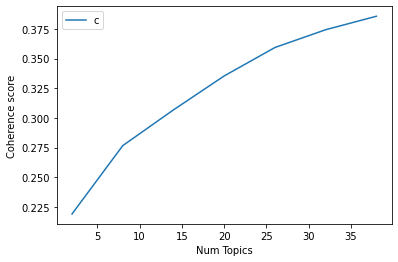

In [52]:
model_list, coherence_values = compute_coherence_values(dictionary=df_mrt_acovid_data_id2word, corpus=df_mrt_acovid_data_corpus, texts=df_mrt_acovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_mrt_acovid_data_model_list = []
# df_mrt_acovid_data_coherence_values = []
# df_mrt_acovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_mrt_acovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_mrt_acovid_data_corpus, id2word=df_mrt_acovid_data_id2word, num_topics=num_topics)
#     df_mrt_acovid_data_coherence_model_lda = CoherenceModel(model=df_mrt_acovid_data_ldamodel, texts=df_mrt_acovid_data_lemmatized, dictionary=df_mrt_acovid_data_id2word, coherence='c_v')
#     df_mrt_acovid_data_model_topics.append(num_topics)
#     df_mrt_acovid_data_model_list.append(df_mrt_acovid_data_lda_x)
#     df_mrt_acovid_data_coherence_values.append(df_mrt_acovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_mrt_acovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_mrt_acovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_mrt_acovid_data_ldamodel.log_perplexity(df_mrt_acovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_mrt_acovid_data_coherence_model_lda = CoherenceModel(model=df_mrt_acovid_data_ldamodel, texts=df_mrt_acovid_data_lemmatized, dictionary=df_mrt_acovid_data_id2word, coherence='c_v')
# df_mrt_acovid_data_coherence_lda = df_mrt_acovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_mrt_acovid_data_coherence_lda)


## Taxi

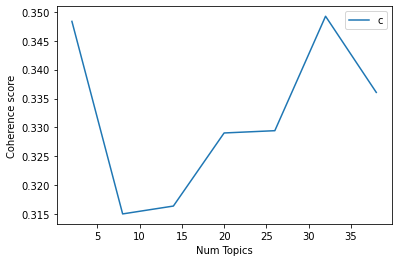

In [53]:
model_list, coherence_values = compute_coherence_values(dictionary=df_taxi_bcovid_data_id2word, corpus=df_taxi_bcovid_data_corpus, texts=df_taxi_bcovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_taxi_bcovid_data_model_list = []
# df_taxi_bcovid_data_coherence_values = []
# df_taxi_bcovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_taxi_bcovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_taxi_bcovid_data_corpus, id2word=df_taxi_bcovid_data_id2word, num_topics=num_topics)
#     df_taxi_bcovid_data_coherence_model_lda = CoherenceModel(model=df_taxi_bcovid_data_ldamodel, texts=df_taxi_bcovid_data_lemmatized, dictionary=df_taxi_bcovid_data_id2word, coherence='c_v')
#     df_taxi_bcovid_data_model_topics.append(num_topics)
#     df_taxi_bcovid_data_model_list.append(df_taxi_bcovid_data_lda_x)
#     df_taxi_bcovid_data_coherence_values.append(df_taxi_bcovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_taxi_bcovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_taxi_bcovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_taxi_bcovid_data_ldamodel.log_perplexity(df_taxi_bcovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_taxi_bcovid_data_coherence_model_lda = CoherenceModel(model=df_taxi_bcovid_data_ldamodel, texts=df_taxi_bcovid_data_lemmatized, dictionary=df_taxi_bcovid_data_id2word, coherence='c_v')
# df_taxi_bcovid_data_coherence_lda = df_taxi_bcovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_taxi_bcovid_data_coherence_lda)


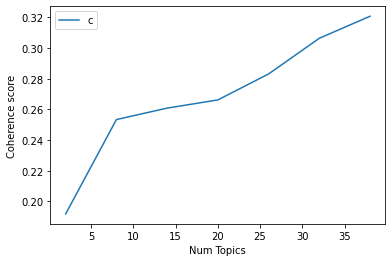

In [54]:
model_list, coherence_values = compute_coherence_values(dictionary=df_taxi_acovid_data_id2word, corpus=df_taxi_acovid_data_corpus, texts=df_taxi_acovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_taxi_acovid_data_model_list = []
# df_taxi_acovid_data_coherence_values = []
# df_taxi_acovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_taxi_acovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_taxi_acovid_data_corpus, id2word=df_taxi_acovid_data_id2word, num_topics=num_topics)
#     df_taxi_acovid_data_coherence_model_lda = CoherenceModel(model=df_taxi_acovid_data_ldamodel, texts=df_taxi_acovid_data_lemmatized, dictionary=df_taxi_acovid_data_id2word, coherence='c_v')
#     df_taxi_acovid_data_model_topics.append(num_topics)
#     df_taxi_acovid_data_model_list.append(df_taxi_acovid_data_lda_x)
#     df_taxi_acovid_data_coherence_values.append(df_taxi_acovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_taxi_acovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_taxi_acovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_taxi_acovid_data_ldamodel.log_perplexity(df_taxi_acovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_taxi_acovid_data_coherence_model_lda = CoherenceModel(model=df_taxi_acovid_data_ldamodel, texts=df_taxi_acovid_data_lemmatized, dictionary=df_taxi_acovid_data_id2word, coherence='c_v')
# df_taxi_acovid_data_coherence_lda = df_taxi_acovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_taxi_acovid_data_coherence_lda)


## Private Hire

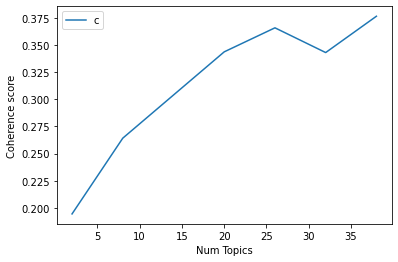

In [55]:
model_list, coherence_values = compute_coherence_values(dictionary=df_ph_bcovid_data_id2word, corpus=df_ph_bcovid_data_corpus, texts=df_ph_bcovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_ph_bcovid_data_model_list = []
# df_ph_bcovid_data_coherence_values = []
# df_ph_bcovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_ph_bcovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_ph_bcovid_data_corpus, id2word=df_ph_bcovid_data_id2word, num_topics=num_topics)
#     df_ph_bcovid_data_coherence_model_lda = CoherenceModel(model=df_ph_bcovid_data_ldamodel, texts=df_ph_bcovid_data_lemmatized, dictionary=df_ph_bcovid_data_id2word, coherence='c_v')
#     df_ph_bcovid_data_model_topics.append(num_topics)
#     df_ph_bcovid_data_model_list.append(df_ph_bcovid_data_lda_x)
#     df_ph_bcovid_data_coherence_values.append(df_ph_bcovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_ph_bcovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_ph_bcovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_ph_bcovid_data_ldamodel.log_perplexity(df_ph_bcovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_ph_bcovid_data_coherence_model_lda = CoherenceModel(model=df_ph_bcovid_data_ldamodel, texts=df_ph_bcovid_data_lemmatized, dictionary=df_ph_bcovid_data_id2word, coherence='c_v')
# df_ph_bcovid_data_coherence_lda = df_ph_bcovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_ph_bcovid_data_coherence_lda)


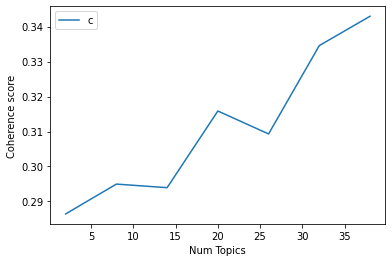

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=df_ph_acovid_data_id2word, corpus=df_ph_acovid_data_corpus, texts=df_ph_acovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# df_ph_acovid_data_model_list = []
# df_ph_acovid_data_coherence_values = []
# df_ph_acovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_ph_acovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_ph_acovid_data_corpus, id2word=df_ph_acovid_data_id2word, num_topics=num_topics)
#     df_ph_acovid_data_coherence_model_lda = CoherenceModel(model=df_ph_acovid_data_ldamodel, texts=df_ph_acovid_data_lemmatized, dictionary=df_ph_acovid_data_id2word, coherence='c_v')
#     df_ph_acovid_data_model_topics.append(num_topics)
#     df_ph_acovid_data_model_list.append(df_ph_acovid_data_lda_x)
#     df_ph_acovid_data_coherence_values.append(df_ph_acovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_ph_acovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_ph_acovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_ph_acovid_data_ldamodel.log_perplexity(df_ph_acovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_ph_acovid_data_coherence_model_lda = CoherenceModel(model=df_ph_acovid_data_ldamodel, texts=df_ph_acovid_data_lemmatized, dictionary=df_ph_acovid_data_id2word, coherence='c_v')
# df_ph_acovid_data_coherence_lda = df_ph_acovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_ph_acovid_data_coherence_lda)


## Car Rental

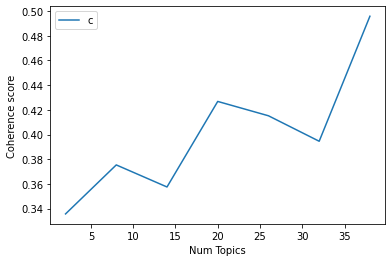

In [57]:
model_list, coherence_values = compute_coherence_values(dictionary=df_cr_bcovid_data_id2word, corpus=df_cr_bcovid_data_corpus, texts=df_cr_bcovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


# df_cr_bcovid_data_model_list = []
# df_cr_bcovid_data_coherence_values = []
# df_cr_bcovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_cr_bcovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_cr_bcovid_data_corpus, id2word=df_cr_bcovid_data_id2word, num_topics=num_topics)
#     df_cr_bcovid_data_coherence_model_lda = CoherenceModel(model=df_cr_bcovid_data_ldamodel, texts=df_cr_bcovid_data_lemmatized, dictionary=df_cr_bcovid_data_id2word, coherence='c_v')
#     df_cr_bcovid_data_model_topics.append(num_topics)
#     df_cr_bcovid_data_model_list.append(df_cr_bcovid_data_lda_x)
#     df_cr_bcovid_data_coherence_values.append(df_cr_bcovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_cr_bcovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_cr_bcovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_cr_bcovid_data_ldamodel.log_perplexity(df_cr_bcovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_cr_bcovid_data_coherence_model_lda = CoherenceModel(model=df_cr_bcovid_data_ldamodel, texts=df_cr_bcovid_data_lemmatized, dictionary=df_cr_bcovid_data_id2word, coherence='c_v')
# df_cr_bcovid_data_coherence_lda = df_cr_bcovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_cr_bcovid_data_coherence_lda)


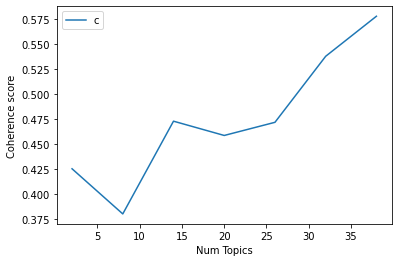

In [58]:
model_list, coherence_values = compute_coherence_values(dictionary=df_cr_acovid_data_id2word, corpus=df_cr_acovid_data_corpus, texts=df_cr_acovid_data_lemmatized, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


# df_cr_acovid_data_model_list = []
# df_cr_acovid_data_coherence_values = []
# df_cr_acovid_data_model_topics = []

# for num_topics in range(5, 40,5):
#     df_cr_acovid_data_lda_x = gensim.models.ldamodel.LdaModel(corpus=df_cr_acovid_data_corpus, id2word=df_cr_acovid_data_id2word, num_topics=num_topics)
#     df_cr_acovid_data_coherence_model_lda = CoherenceModel(model=df_cr_acovid_data_ldamodel, texts=df_cr_acovid_data_lemmatized, dictionary=df_cr_acovid_data_id2word, coherence='c_v')
#     df_cr_acovid_data_model_topics.append(num_topics)
#     df_cr_acovid_data_model_list.append(df_cr_acovid_data_lda_x)
#     df_cr_acovid_data_coherence_values.append(df_cr_acovid_data_coherence_model_lda.get_coherence())
#     print("#Topics: " + str(num_topics) + " Score: " + str(df_cr_acovid_data_coherence_model_lda.get_coherence()))

# #to show plot
# limit=40; start=5; step=5;
# x = range(start, limit, step)
# plt.plot(x, df_cr_acovid_data_coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

# # Compute Perplexity
# print('\nPerplexity: ', df_cr_acovid_data_ldamodel.log_perplexity(df_cr_acovid_data_corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# df_cr_acovid_data_coherence_model_lda = CoherenceModel(model=df_cr_acovid_data_ldamodel, texts=df_cr_acovid_data_lemmatized, dictionary=df_cr_acovid_data_id2word, coherence='c_v')
# df_cr_acovid_data_coherence_lda = df_cr_acovid_data_coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', df_cr_acovid_data_coherence_lda)


# Visualize the topics

Now that the LDA model is built, the next step is to examine the produced 
topics and the associated keywords. There is no better tool than pyLDAvis package’s 
interactive chart and is designed to work well with jupyter notebooks.

In [59]:
df_bcovid_data_ldamodel = lda_model(df_bcovid_data_corpus, df_bcovid_data_id2word, 15)
df_acovid_data_ldamodel = lda_model(df_acovid_data_corpus, df_acovid_data_id2word, 20)

df_bus_bcovid_data_ldamodel = lda_model(df_bus_bcovid_data_corpus, df_bus_bcovid_data_id2word, 25)
df_bus_acovid_data_ldamodel = lda_model(df_bus_acovid_data_corpus, df_bus_acovid_data_id2word, 20)

df_mrt_bcovid_data_ldamodel = lda_model(df_mrt_bcovid_data_corpus, df_mrt_bcovid_data_id2word, 20)
df_mrt_acovid_data_ldamodel = lda_model(df_mrt_acovid_data_corpus, df_mrt_acovid_data_id2word, 25)

df_taxi_bcovid_data_ldamodel = lda_model(df_taxi_bcovid_data_corpus, df_taxi_bcovid_data_id2word, 15)
df_taxi_acovid_data_ldamodel = lda_model(df_taxi_acovid_data_corpus, df_taxi_acovid_data_id2word, 15)

df_ph_bcovid_data_ldamodel = lda_model(df_ph_bcovid_data_corpus, df_ph_bcovid_data_id2word, 10)
df_ph_acovid_data_ldamodel = lda_model(df_ph_acovid_data_corpus, df_ph_acovid_data_id2word, 20)

df_cr_bcovid_data_ldamodel = lda_model(df_cr_bcovid_data_corpus, df_cr_bcovid_data_id2word, 20)
df_cr_acovid_data_ldamodel = lda_model(df_cr_acovid_data_corpus, df_cr_acovid_data_id2word, 14)

In [60]:
df_bcovid_data_doc_lda = df_bcovid_data_ldamodel[df_bcovid_data_corpus]
df_acovid_data_doc_lda = df_acovid_data_ldamodel[df_acovid_data_corpus]

df_bus_bcovid_data_doc_lda = df_bus_bcovid_data_ldamodel[df_bus_bcovid_data_corpus]
df_bus_acovid_data_doc_lda = df_bus_acovid_data_ldamodel[df_bus_acovid_data_corpus]

df_mrt_bcovid_data_doc_lda = df_mrt_bcovid_data_ldamodel[df_mrt_bcovid_data_corpus]
df_mrt_acovid_data_doc_lda = df_mrt_acovid_data_ldamodel[df_mrt_acovid_data_corpus]

df_taxi_bcovid_data_doc_lda = df_taxi_bcovid_data_ldamodel[df_taxi_bcovid_data_corpus]
df_taxi_acovid_data_doc_lda = df_taxi_acovid_data_ldamodel[df_taxi_acovid_data_corpus]

df_ph_bcovid_data_doc_lda = df_ph_bcovid_data_ldamodel[df_ph_bcovid_data_corpus]
df_ph_acovid_data_doc_lda = df_ph_acovid_data_ldamodel[df_ph_acovid_data_corpus]

df_cr_bcovid_data_doc_lda = df_cr_bcovid_data_ldamodel[df_cr_bcovid_data_corpus]
df_cr_acovid_data_doc_lda = df_cr_acovid_data_ldamodel[df_cr_acovid_data_corpus]

## Overall

In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_bcovid_data_ldamodel,
                              df_bcovid_data_corpus, 
                              df_bcovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.344540  0.168206       1        1  18.703195
13     0.169589 -0.384853       2        1  12.754989
7      0.187874  0.147529       3        1  12.229525
3      0.033432 -0.040157       4        1   9.626474
4      0.029978 -0.076275       5        1   7.970942
5     -0.016559 -0.003752       6        1   5.574802
12    -0.047455  0.010201       7        1   5.317314
14    -0.072032  0.018576       8        1   4.568822
0     -0.051589  0.011755       9        1   4.554642
9     -0.088262  0.023002      10        1   3.737098
6     -0.085391  0.022277      11        1   3.732146
2     -0.094488  0.024492      12        1   3.390476
11    -0.098337  0.025347      13        1   3.112644
1     -0.106589  0.027001      14        1   2.630693
10    -0.104711  0.026652      15        1   2.096238, topic_info=           Term         Freq        Total Category  logprob  loglift
65         time  1415.000000  1415.000000  Default  30.0000  30.0000
216         end   941.000000   941.000000  Default  29.0000  29.0000
539         pay   759.000000   759.000000  Default  28.0000  28.0000
58         need   827.000000   827.000000  Default  27.0000  27.0000
34      service   582.000000   582.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3496   resource     0.063628     1.282476  Topic15 -10.5103   0.8615
1259    benefit     0.064722     1.317223  Topic15 -10.4932   0.8518
1932      fleet     0.064161     1.299689  Topic15 -10.5020   0.8565
2616  peak_hour     0.064277     1.320240  Topic15 -10.5001   0.8427
1782     factor     0.064370     1.335349  Topic15 -10.4987   0.8327

[506 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
588       4  0.994494      able
1095      8  0.980387    accept
518       7  0.989980    access
21        7  0.992726  accident
1278      1  0.995831       add
...     ...       ...       ...
1355      2  0.995982     wrong
836       4  0.995367       www
420      13  0.985424    yellow
731       7  0.998021       yet
512       3  0.992163     young

[423 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 14, 8, 4, 5, 6, 13, 15, 1, 10, 7, 3, 12, 2, 11])

In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_acovid_data_ldamodel,
                              df_acovid_data_corpus, 
                              df_acovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19    -0.252034 -0.366408       1        1  14.117702
11    -0.235550  0.272185       2        1  13.456568
4     -0.228378  0.105924       3        1  12.675618
8     -0.137204  0.010897       4        1   8.270505
13    -0.063338  0.002674       5        1   6.028817
15    -0.013068  0.000081       6        1   4.906653
5      0.001855 -0.000495       7        1   4.791186
1     -0.014053  0.000119       8        1   4.744780
7      0.008752 -0.000678       9        1   4.269301
0      0.023679 -0.001144      10        1   4.099323
14     0.025457 -0.001172      11        1   3.973865
3      0.056100 -0.001919      12        1   3.281739
17     0.034633 -0.001412      13        1   3.213971
10     0.076590 -0.002287      14        1   2.649345
2      0.090766 -0.002510      15        1   2.323699
12     0.101157 -0.002644      16        1   2.038616
16     0.096669 -0.002577      17        1   1.841362
9      0.113271 -0.002772      18        1   1.756661
6      0.155566 -0.002942      19        1   0.893246
18     0.159131 -0.002921      20        1   0.667044, topic_info=           Term         Freq        Total Category  logprob  loglift
79      service  2244.000000  2244.000000  Default  30.0000  30.0000
91         time  4240.000000  4240.000000  Default  29.0000  29.0000
354        work  3555.000000  3555.000000  Default  28.0000  28.0000
6           new  1468.000000  1468.000000  Default  27.0000  27.0000
389     company  2468.000000  2468.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
12187  business     0.047671     1.544044  Topic20 -10.4937   1.5322
1221    country     0.047655     1.540988  Topic20 -10.4941   1.5339
1005   increase     0.047653     1.540627  Topic20 -10.4941   1.5341
1070      allow     0.047653     1.540307  Topic20 -10.4941   1.5343
1349     number     0.047652     1.540762  Topic20 -10.4941   1.5340

[731 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
786      11  0.905473     abandon
692       1  0.998570        able
488      16  0.976633  accessible
880      10  0.996301    accident
44        8  0.992467    activity
...     ...       ...         ...
744       2  0.998917      worker
298      18  0.995694       world
441       8  0.992285       worth
893      10  0.998421       wrong
511      16  0.997136         www

[486 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 12, 5, 9, 14, 16, 6, 2, 8, 1, 15, 4, 18, 11, 3, 13, 17, 10, 7, 19])

## Bus

In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_bus_bcovid_data_ldamodel,
                              df_bus_bcovid_data_corpus, 
                              df_bus_bcovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.352685  0.090927       1        1  21.300772
7     -0.188120 -0.124057       2        1  10.974531
1     -0.164811 -0.168560       3        1   9.652268
21    -0.108402 -0.059287       4        1   8.467601
23    -0.145237 -0.244818       5        1   7.629043
4     -0.242769  0.241189       6        1   7.565879
5     -0.121783  0.145375       7        1   5.186124
15    -0.025493 -0.015338       8        1   4.553760
24     0.005983 -0.009940       9        1   4.099003
14    -0.011883  0.013893      10        1   3.357363
0      0.048966 -0.033836      11        1   2.444474
22     0.050831  0.004511      12        1   2.304132
19     0.073922  0.018346      13        1   2.282371
13     0.048777 -0.009365      14        1   2.232311
20     0.060043  0.011536      15        1   1.911894
2      0.092024  0.014656      16        1   1.019597
10     0.103371  0.014659      17        1   0.954847
6      0.101526  0.016864      18        1   0.949322
18     0.107615  0.016310      19        1   0.811387
8      0.110072  0.013987      20        1   0.638883
17     0.110316  0.013795      21        1   0.633606
9      0.110697  0.013534      22        1   0.465837
16     0.112393  0.012660      23        1   0.271883
12     0.112534  0.012137      24        1   0.202343
11     0.112112  0.010825      25        1   0.090769, topic_info=           Term        Freq       Total Category  logprob  loglift
544     service  278.000000  278.000000  Default   30.000  30.0000
800       place  356.000000  356.000000  Default   29.000  29.0000
126        mean  341.000000  341.000000  Default   28.000  28.0000
83         time  669.000000  669.000000  Default   27.000  27.0000
142        take  403.000000  403.000000  Default   26.000  26.0000
...         ...         ...         ...      ...      ...      ...
1588       lack    0.006145    1.203510  Topic25   -8.914   1.7272
2805  important    0.006145    1.203510  Topic25   -8.914   1.7272
1674     answer    0.006145    1.203510  Topic25   -8.914   1.7272
1798      datum    0.006145    1.203510  Topic25   -8.914   1.7272
2164        law    0.006145    1.203511  Topic25   -8.914   1.7272

[1006 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
592      16  0.988258      able
1276     17  0.988535     abuse
287       4  0.961567    accept
948      16  0.931071    access
412      18  0.969803  accident
...     ...       ...       ...
764       5  0.965696     worth
343       2  0.992933     wrong
376       3  0.987843       www
1402      1  0.994448       yet
259       2  0.989396     young

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 2, 22, 24, 5, 6, 16, 25, 15, 1, 23, 20, 14, 21, 3, 11, 7, 19, 9, 18, 10, 17, 13, 12])

In [64]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_bus_acovid_data_ldamodel,
                              df_bus_acovid_data_corpus, 
                              df_bus_acovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.400507 -0.281948       1        1  30.768606
18     0.300068  0.346459       2        1  15.660041
12     0.069551  0.004731       3        1   6.582604
5      0.080435  0.024520       4        1   5.963515
19    -0.004396 -0.001002       5        1   4.099386
13    -0.017283 -0.002871       6        1   3.738102
8     -0.016212 -0.002692       7        1   3.599941
4     -0.013434  0.002535       8        1   3.546575
14    -0.034561 -0.004880       9        1   3.337016
11    -0.017517 -0.002849      10        1   3.318536
0     -0.048498 -0.006293      11        1   2.855808
15    -0.054924 -0.006728      12        1   2.663205
10    -0.053404 -0.006750      13        1   2.604628
9     -0.062249 -0.007460      14        1   2.185610
6     -0.082727 -0.008899      15        1   1.911157
17    -0.067924 -0.007910      16        1   1.851837
2     -0.085673 -0.009070      17        1   1.658249
1     -0.086774 -0.009132      18        1   1.532229
3     -0.092457 -0.009439      19        1   1.401833
16    -0.112529 -0.010325      20        1   0.721122, topic_info=          Term         Freq        Total Category  logprob  loglift
282   business  2171.000000  2171.000000  Default  30.0000  30.0000
111    service  1360.000000  1360.000000  Default  29.0000  29.0000
152        new   780.000000   780.000000  Default  28.0000  28.0000
207      first   692.000000   692.000000  Default  27.0000  27.0000
48        time  2001.000000  2001.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2089      fare     0.050288     1.646717  Topic20  -9.8678   1.4434
1594      hold     0.050289     1.646766  Topic20  -9.8678   1.4433
1238    market     0.050290     1.647098  Topic20  -9.8678   1.4431
1127       com     0.050289     1.647194  Topic20  -9.8678   1.4431
1120       job     0.050289     1.647719  Topic20  -9.8678   1.4428

[740 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
693      11  0.995851        abuse
533       5  0.971668   accessible
427      12  0.989022     accident
975      16  0.894413       accuse
750       6  0.925986  acknowledge
...     ...       ...          ...
654       1  0.876194         work
654       2  0.122874         work
31        8  0.996286       worker
686       4  0.991407        world
50        7  0.987378          yet

[513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 19, 13, 6, 20, 14, 9, 5, 15, 12, 1, 16, 11, 10, 7, 18, 3, 2, 4, 17])

## MRT

In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_mrt_bcovid_data_ldamodel,
                              df_mrt_bcovid_data_corpus, 
                              df_mrt_bcovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.323017 -0.321632       1        1  28.058427
15    -0.363892  0.268154       2        1  26.707622
6     -0.166608  0.066183       3        1   9.550821
4     -0.056154 -0.064592       4        1   6.843139
5     -0.023241  0.029661       5        1   5.712099
8     -0.020628 -0.003970       6        1   5.202065
7      0.036977  0.006242       7        1   2.805957
18     0.052608  0.009120       8        1   2.534973
16     0.056949  0.004947       9        1   1.733338
12     0.069306  0.003609      10        1   1.643713
0      0.061889  0.001850      11        1   1.540881
19     0.061151 -0.019640      12        1   1.349798
3      0.075609  0.003846      13        1   1.134417
17     0.077502  0.002489      14        1   0.921655
13     0.077717  0.002297      15        1   0.893055
10     0.074235  0.003076      16        1   0.889696
14     0.077890  0.002340      17        1   0.822091
11     0.077179  0.002465      18        1   0.813069
2      0.077009  0.002453      19        1   0.623222
9      0.077519  0.001100      20        1   0.219962, topic_info=            Term        Freq       Total Category  logprob  loglift
869         work  192.000000  192.000000  Default  30.0000  30.0000
0           door  151.000000  151.000000  Default  29.0000  29.0000
13        system  341.000000  341.000000  Default  28.0000  28.0000
447        maybe  169.000000  169.000000  Default  27.0000  27.0000
118         look  309.000000  309.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1940       court    0.010744    0.988641  Topic20  -8.7526   1.5975
2451  difference    0.010744    0.988659  Topic20  -8.7526   1.5975
1772   generally    0.010744    0.988756  Topic20  -8.7526   1.5974
1112       small    0.010744    0.988706  Topic20  -8.7526   1.5974
1383       child    0.010744    0.988772  Topic20  -8.7526   1.5974

[780 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
373       2  0.902547           able
373       3  0.091166           able
727      13  0.909077             ad
809      16  0.799979  advertisement
975      18  0.685607    advertising
...     ...       ...            ...
647      10  0.714072          world
839       5  0.966054          worth
276       7  0.954192            www
179      14  0.855850     www_reddit
152       1  0.990080          young

[454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 16, 7, 5, 6, 9, 8, 19, 17, 13, 1, 20, 4, 18, 14, 11, 15, 12, 3, 10])

In [66]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_mrt_acovid_data_ldamodel,
                              df_mrt_acovid_data_corpus, 
                              df_mrt_acovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21    -0.277806 -0.315195       1        1  14.163003
23    -0.311529  0.295508       2        1  13.679286
2     -0.130062 -0.008119       3        1   8.819088
9     -0.095546 -0.004114       4        1   8.627800
11    -0.120253 -0.006877       5        1   8.162282
8     -0.046390 -0.000612       6        1   6.575705
14    -0.010132  0.000989       7        1   4.294315
5      0.015218  0.001785       8        1   3.914351
17     0.010675  0.001669       9        1   3.783388
1      0.016812  0.001875      10        1   3.673209
4      0.009572  0.001660      11        1   3.642660
7      0.018883  0.001899      12        1   3.631925
10     0.045347  0.002368      13        1   3.105031
6      0.053889  0.002435      14        1   2.118697
16     0.067930  0.002436      15        1   1.804143
19     0.059346  0.002463      16        1   1.728175
18     0.071925  0.002401      17        1   1.479508
20     0.075377  0.002337      18        1   1.161949
0      0.075623  0.002302      19        1   1.039266
13     0.076685  0.002275      20        1   1.018745
15     0.074154  0.002348      21        1   0.949291
12     0.076498  0.002271      22        1   0.871465
24     0.078754  0.002173      23        1   0.825331
3      0.081708  0.001970      24        1   0.575673
22     0.083323  0.001753      25        1   0.355715, topic_info=          Term         Freq        Total Category  logprob  loglift
229       time  2100.000000  2100.000000  Default  30.0000  30.0000
49        work  1404.000000  1404.000000  Default  29.0000  29.0000
220   training   995.000000   995.000000  Default  28.0000  28.0000
211       good  1106.000000  1106.000000  Default  27.0000  27.0000
250      right   611.000000   611.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
486       seat     0.023598     2.108023  Topic25  -9.3192   1.1464
1314    reason     0.023598     2.108027  Topic25  -9.3192   1.1464
747    usually     0.023597     2.108023  Topic25  -9.3192   1.1464
729       mean     0.023597     2.108030  Topic25  -9.3192   1.1464
828    comment     0.023597     2.108031  Topic25  -9.3192   1.1464

[1100 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
255      23  0.871648  absolutely
50        1  0.983048      accept
125      18  0.874735    accurate
70        3  0.978745          ad
214       6  0.993933         add
...     ...       ...         ...
393       7  0.990292      worker
47        4  0.944404     working
375       1  0.991457       world
69       10  0.994179       wrong
436      11  0.850290   yesterday

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 24, 3, 10, 12, 9, 15, 6, 18, 2, 5, 8, 11, 7, 17, 20, 19, 21, 1, 14, 16, 13, 25, 4, 23])

## Taxi

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_taxi_bcovid_data_ldamodel,
                              df_taxi_bcovid_data_corpus, 
                              df_taxi_bcovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.291557  0.315408       1        1  19.997130
11    -0.222072 -0.214024       2        1  16.532877
8     -0.188710 -0.191358       3        1  14.670325
6     -0.017364 -0.020659       4        1   8.790844
1     -0.000951 -0.011167       5        1   7.848159
4      0.037166  0.023883       6        1   6.585942
13     0.045708  0.018070       7        1   6.536077
14     0.070591  0.010674       8        1   3.873850
0      0.075634  0.010393       9        1   3.745852
5      0.071269  0.017158      10        1   3.721495
3      0.077577  0.010761      11        1   2.826254
9      0.083744  0.009433      12        1   2.037043
2      0.086280  0.006704      13        1   1.325644
12     0.086360  0.007366      14        1   0.795929
7      0.086325  0.007358      15        1   0.712579, topic_info=            Term        Freq       Total Category  logprob  loglift
48         drive  302.000000  302.000000  Default  30.0000  30.0000
66          time  313.000000  313.000000  Default  29.0000  29.0000
413        cheap  117.000000  117.000000  Default  28.0000  28.0000
538          pay  197.000000  197.000000  Default  27.0000  27.0000
467        price  135.000000  135.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1142        wish    0.026591    1.114555  Topic15  -8.6574   1.2084
1713     process    0.026554    1.110139  Topic15  -8.6588   1.2110
1320         coe    0.026447    1.097800  Topic15  -8.6629   1.2181
1062   behaviour    0.026429    1.097866  Topic15  -8.6635   1.2174
1102  personally    0.026399    1.095069  Topic15  -8.6647   1.2188

[546 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
226       9  0.619350  absolute_failure
518       8  0.884474            access
21        4  0.874656          accident
21       13  0.104126          accident
1272      3  0.988922               add
...     ...       ...               ...
793       2  0.969374               www
621      14  0.400988               yea
420      13  0.935035            yellow
728       7  0.919069               yet
512       4  0.960190             young

[430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 9, 7, 2, 5, 14, 15, 1, 6, 4, 10, 3, 13, 8])

In [68]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_taxi_acovid_data_ldamodel,
                              df_taxi_acovid_data_corpus, 
                              df_taxi_acovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.263741  0.033718       1        1  17.575859
10    -0.211311  0.081961       2        1  16.145482
13    -0.205867  0.182651       3        1  15.883601
12    -0.159944 -0.365581       4        1  15.422575
4      0.066226  0.007577       5        1   4.838088
2      0.064553  0.006860       6        1   4.642452
3      0.066553  0.004874       7        1   4.629868
6      0.063798 -0.003989       8        1   4.557537
8      0.077436  0.006630       9        1   3.489202
5      0.074909  0.006242      10        1   3.334956
0      0.077733  0.007308      11        1   3.196463
9      0.083251  0.007466      12        1   2.674506
11     0.088265  0.008041      13        1   1.464716
7      0.088565  0.008082      14        1   1.409764
14     0.089575  0.008161      15        1   0.734931, topic_info=            Term        Freq       Total Category  logprob  loglift
256      cyclist  341.000000  341.000000  Default  30.0000  30.0000
98          cost  131.000000  131.000000  Default  29.0000  29.0000
478        right  143.000000  143.000000  Default  28.0000  28.0000
261         road  242.000000  242.000000  Default  27.0000  27.0000
358         work  240.000000  240.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2443        list    0.029663    1.167072  Topic15  -8.8796   1.2408
5031      forest    0.030061    1.185074  Topic15  -8.8662   1.2388
1440       staff    0.029761    1.171817  Topic15  -8.8762   1.2401
3448  assumption    0.029780    1.178859  Topic15  -8.8756   1.2347
5026     destroy    0.029646    1.170671  Topic15  -8.8801   1.2371

[507 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
691       3  0.973058        able
288       9  0.932223  absolutely
454       1  0.975374      accept
879       4  0.991737    accident
43        7  0.917299    activity
...     ...       ...         ...
444      14  0.427048     working
301       8  0.961585       world
445       9  0.951892       worth
892       4  0.990617       wrong
511       1  0.983972         www

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 14, 13, 5, 3, 4, 7, 9, 6, 1, 10, 12, 8, 15])

## Private Hire

In [69]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_ph_bcovid_data_ldamodel,
                              df_ph_bcovid_data_corpus, 
                              df_ph_bcovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.268036  0.157276       1        1  33.221575
1      0.148848 -0.171530       2        1  13.648696
9      0.011237 -0.137861       3        1  10.449454
4     -0.117746 -0.029059       4        1   8.889971
2     -0.124098  0.128713       5        1   8.501966
8     -0.033901 -0.066294       6        1   8.360874
6     -0.044460  0.061984       7        1   7.495366
0     -0.050438  0.014733       8        1   4.184131
3     -0.032961  0.028556       9        1   3.878090
5     -0.024518  0.013482      10        1   1.369877, topic_info=         Term       Freq      Total Category  logprob  loglift
112   service  32.000000  32.000000  Default  30.0000  30.0000
327       com  22.000000  22.000000  Default  29.0000  29.0000
194      ride  45.000000  45.000000  Default  28.0000  28.0000
358       use  36.000000  36.000000  Default  27.0000  27.0000
156     drive  53.000000  53.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
1339   apnews   0.241653   0.890527  Topic10  -6.0988   2.9861
1340    ebfaa   0.241653   0.890527  Topic10  -6.0988   2.9861
1342   impact   0.241653   0.890527  Topic10  -6.0988   2.9861
10        die   0.462494   2.607528  Topic10  -5.4497   2.5609
881    system   0.594352  11.107211  Topic10  -5.1989   1.3626

[449 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
958       8  0.915179  absolutely
1199      3  0.940821         add
1708      7  0.660064  additional
169       8  0.931718      affect
2063      8  0.854580  affordable
...     ...       ...         ...
51        9  0.189567       wrong
1429      4  0.925110         www
267       9  0.688118       young
2189      4  0.749851     youtube
851       8  0.830924    youtuber

[507 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 10, 5, 3, 9, 7, 1, 4, 6])

In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_ph_acovid_data_ldamodel,
                              df_ph_acovid_data_corpus, 
                              df_ph_acovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.433495 -0.165518       1        1  36.823846
9      0.166117  0.376013       2        1  12.612506
17     0.044865  0.002182       3        1   7.425818
4      0.054050 -0.024087       4        1   6.755148
11     0.012503  0.012295       5        1   5.629639
14    -0.020469 -0.004201       6        1   4.830443
16    -0.008323 -0.007515       7        1   3.375288
13    -0.026617 -0.007919       8        1   3.337666
0     -0.046260 -0.013436       9        1   2.936398
18    -0.036702 -0.013960      10        1   2.854151
19    -0.053465 -0.008508      11        1   1.946563
10    -0.050663 -0.015719      12        1   1.909868
6     -0.054819 -0.015631      13        1   1.646598
15    -0.057138 -0.016081      14        1   1.451076
3     -0.057776 -0.016205      15        1   1.449159
8     -0.058870 -0.016368      16        1   1.210275
12    -0.060184 -0.015812      17        1   1.146294
1     -0.059368 -0.016428      18        1   1.121901
5     -0.060048 -0.016755      19        1   0.869961
2     -0.060328 -0.016348      20        1   0.667403, topic_info=         Term        Freq       Total Category  logprob  loglift
286      good  190.000000  190.000000  Default  30.0000  30.0000
90      money  119.000000  119.000000  Default  29.0000  29.0000
254       app  140.000000  140.000000  Default  28.0000  28.0000
85    company  109.000000  109.000000  Default  27.0000  27.0000
121     order  133.000000  133.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1194     safe    0.023869    1.063807  Topic20  -8.6755   1.2125
1055  support    0.023869    1.063908  Topic20  -8.6755   1.2124
1384      add    0.023869    1.063814  Topic20  -8.6755   1.2125
1199     slow    0.023869    1.063733  Topic20  -8.6755   1.2126
1237    panda    0.023869    1.063728  Topic20  -8.6755   1.2126

[742 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
283       5  0.910545        act
252       4  0.935519  advantage
771       9  0.902957     afford
39       13  0.948334        ago
219       2  0.977554      agree
...     ...       ...        ...
102      18  0.741443        win
266       1  0.997356       work
491       3  0.938518     worker
870      12  0.861275      worry
268      16  0.815552  yesterday

[437 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 18, 5, 12, 15, 17, 14, 1, 19, 20, 11, 7, 16, 4, 9, 13, 2, 6, 3])

## Car Rental

In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_cr_bcovid_data_ldamodel,
                              df_cr_bcovid_data_corpus, 
                              df_cr_bcovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.246106 -0.087154       1        1  23.561989
4     -0.087035  0.085871       2        1  11.354961
8     -0.125064 -0.041718       3        1   9.111370
14     0.068657  0.100660       4        1   7.742955
10    -0.043647  0.027166       5        1   6.189435
17    -0.064021 -0.143369       6        1   5.901571
7     -0.009265  0.134237       7        1   5.151440
11     0.022568  0.066327       8        1   4.990056
3     -0.061271 -0.072474       9        1   4.749612
16    -0.042886 -0.074791      10        1   3.273772
18     0.015134  0.045227      11        1   3.077492
2     -0.016402  0.042914      12        1   3.066384
1     -0.006168 -0.012201      13        1   2.218038
19     0.010260 -0.005755      14        1   2.109538
15    -0.005161 -0.047848      15        1   1.905203
5      0.048115  0.019049      16        1   1.797153
12     0.011914 -0.003216      17        1   1.695867
9      0.021305  0.000738      18        1   1.308789
13     0.015007 -0.013284      19        1   0.681028
6      0.001854 -0.020377      20        1   0.113347, topic_info=          Term       Freq      Total Category  logprob  loglift
10     company  21.000000  21.000000  Default  30.0000  30.0000
305        com   9.000000   9.000000  Default  29.0000  29.0000
176       rent  20.000000  20.000000  Default  28.0000  28.0000
62        card   6.000000   6.000000  Default  27.0000  27.0000
256  insurance  11.000000  11.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
523     couple   0.002121   1.897501  Topic20  -6.6334  -0.0141
606       give   0.002119   1.897523  Topic20  -6.6343  -0.0150
151      never   0.002119   1.994517  Topic20  -6.6343  -0.0649
261   maintain   0.002118   1.896918  Topic20  -6.6344  -0.0148
400     happen   0.002118   2.550138  Topic20  -6.6345  -0.3108

[943 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
45        1  0.478403    accept
45        8  0.478403    accept
365       6  0.434038  accident
46        1  0.853520       act
47        1  0.853549  activity
...     ...       ...       ...
297       2  0.504392       yet
297       9  0.504392       yet
612       8  0.443635     young
612      11  0.443635     young
684       3  0.761935        yr

[719 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 9, 15, 11, 18, 8, 12, 4, 17, 19, 3, 2, 20, 16, 6, 13, 10, 14, 7])

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_cr_acovid_data_ldamodel,
                              df_cr_acovid_data_corpus, 
                              df_cr_acovid_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.147689 -0.141634       1        1  29.036487
12     0.166320  0.184563       2        1  18.412051
8     -0.157533  0.085074       3        1   9.492977
1     -0.037820 -0.105995       4        1   8.742850
13    -0.012676 -0.005284       5        1   7.913265
10    -0.022287 -0.074688       6        1   6.911068
6     -0.055412  0.031057       7        1   6.007545
9     -0.015884 -0.002313       8        1   4.348364
3     -0.005284 -0.006969       9        1   2.307958
7     -0.002289 -0.001305      10        1   2.011676
4      0.004577  0.005284      11        1   1.688490
2     -0.023882  0.026460      12        1   1.669959
11     0.000132 -0.003701      13        1   1.293473
0      0.014349  0.009451      14        1   0.163835, topic_info=          Term      Freq     Total Category  logprob  loglift
263       rent  6.000000  6.000000  Default  30.0000  30.0000
134    company  9.000000  9.000000  Default  29.0000  29.0000
247       card  3.000000  3.000000  Default  28.0000  28.0000
253        tap  4.000000  4.000000  Default  27.0000  27.0000
80   different  5.000000  5.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
181       neck  0.002634  2.219214  Topic14  -6.2295  -0.3222
192      plate  0.002634  5.360224  Topic14  -6.2295  -1.2041
164     injury  0.002634  2.220441  Topic14  -6.2295  -0.3228
103       tell  0.002634  2.794947  Topic14  -6.2297  -0.5531
200     repair  0.002633  2.891082  Topic14  -6.2299  -0.5871

[693 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
326       6  0.920743         abit
115       1  1.010767     accident
3         2  0.777203  accommodate
327       6  0.920744           ad
278       2  0.776607          add
...     ...       ...          ...
314       1  0.698770        worth
314       5  0.349385        worth
241       3  0.866146        wrong
105       7  0.944893        young
303       7  0.945065         zone

[436 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 13, 9, 2, 14, 11, 7, 10, 4, 8, 5, 3, 12, 1])